# Problem 80

In [1]:
# Execute Problem 50 before executing this cell(Fetching data)
import pandas as pd

df = pd.read_table('./NewsAggregatorDataset/newsCorpora.csv', names=('ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'))

In [2]:
targets = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['PUBLISHER'].isin(targets)]
df = df.sample(frac=1).reset_index(drop=True)
num_train = int(len(df)*0.8)
num_valid_and_test = int(len(df)*0.1)
df_train = df[0:num_train]
df_valid = df[num_train:num_train+num_valid_and_test]
df_test = df[num_train+num_valid_and_test:]

In [3]:
import re
import string

def preprocess_text(s):
    trans_table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    s = s.translate(trans_table)
    s = s.lower()
    s = re.sub('[0-9]+', '0', s)
    s = re.sub('\s+', ' ', s)
    return s

df_train['TITLE'] = df_train['TITLE'].map(preprocess_text)
df_valid['TITLE'] = df_valid['TITLE'].map(preprocess_text)
df_test['TITLE'] = df_test['TITLE'].map(preprocess_text)

<ipython-input-3-4d5351b91d6c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TITLE'] = df_train['TITLE'].map(preprocess_text)
<ipython-input-3-4d5351b91d6c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['TITLE'] = df_valid['TITLE'].map(preprocess_text)
<ipython-input-3-4d5351b91d6c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=2)
vec_cnt = vectorizer.fit_transform(df_train['TITLE']).toarray()
word_sum = vec_cnt.sum(axis=0)

In [5]:
import numpy as np
occurence_sorted_indexes = np.argsort(word_sum)[::-1]
words = np.array(vectorizer.get_feature_names())
words_sorted_by_occurence = words[occurence_sorted_indexes]
print(words_sorted_by_occurence[:30])
word_to_id_dict = {s: i for (i, s) in enumerate(words_sorted_by_occurence)}

['to' 'in' 'the' 'of' 'for' 'on' 'as' 'update' 'us' 'and' 'with' 'at' 'is'
 'after' 'new' 'says' 'up' 'from' 'stocks' 'kardashian' 'by' 'china' 'kim'
 'over' 'her' 'euro' 'it' 'be' 'first' 'will']


In [6]:
def sentence_to_id(s, max_len = 512):
    s = preprocess_text(s)
    s = s.split(' ')
    def word_to_id(word):
        if word in word_to_id_dict:
            return word_to_id_dict[word]
        else:
            return 0
    seq = np.array(list(map(word_to_id, s)))
    padding = (0, max_len - len(seq))
    return np.pad(seq, padding, 'constant', constant_values=0)

In [7]:
sentence_to_id('Amazon Plans to Fight FTC Over Mobile-App Purchases')

array([ 161,  250,    0,  299, 1236,   23,  252,  608, 3056,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# Problem 81

In [18]:
import torch
from torch import nn

class MySimpleRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, output_size):
        super().__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.emb = nn.Embedding(len(words_sorted_by_occurence)+1, embed_size, padding_idx=len(words_sorted_by_occurence))
        self.rnn = nn.RNN(embed_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x_emb = self.emb(x)
        _, h = self.rnn(x_emb)
        y = self.fc(h)
        return y.squeeze()
embed_size = 300
hidden_size = 50
model = MySimpleRNN(embed_size, hidden_size, 4)

In [19]:
from torch.utils.data import Dataset

category_conv_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
label_train = df_train['CATEGORY'].map(lambda x: category_conv_dict[x])
label_valid = df_valid['CATEGORY'].map(lambda x: category_conv_dict[x])
label_test = df_test['CATEGORY'].map(lambda x: category_conv_dict[x])

def to_onehot(val):
    base = torch.zeros(4)
    base.scatter_(0, torch.tensor(val), 1)
    return base

class CreateDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):  # Dataset[index]で返す値を指定
        return torch.tensor(self.x[i]), torch.tensor(self.y[i])
    
ds_train = CreateDataset(df_train['TITLE'].map(sentence_to_id).values, label_train.map(to_onehot))
ds_valid = CreateDataset(df_valid['TITLE'].map(sentence_to_id).values, label_valid.map(to_onehot))
ds_test = CreateDataset(df_test['TITLE'].map(sentence_to_id).values, label_test.map(to_onehot))

In [20]:
ds_train[1]

<ipython-input-19-7d29c699be4b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i]), torch.tensor(self.y[i])


(tensor([7398,    9,    0,   91, 4587, 2774, 2127,  113,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [21]:
from torch.utils.data import DataLoader

dataloader = DataLoader(ds_train, batch_size=2048, shuffle=False)
x, y = ds_train[0]
torch.softmax(model(x.unsqueeze(0)), dim=-1)

<ipython-input-19-7d29c699be4b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i]), torch.tensor(self.y[i])


tensor([0.1599, 0.4070, 0.0848, 0.3483], grad_fn=<SoftmaxBackward>)

# Problem 82-83

In [22]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=1e-2)

loss_fn = nn.BCEWithLogitsLoss()
loss_log = []
model = model.cuda()
for epoch in range(100):
    loss_total = 0.0
    for data in dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        #print(model(x).shape)
        #print(y.shape)
        loss = loss_fn(model(x), y)
        loss_total += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch, loss_total)
    loss_log.append(loss_total)

<ipython-input-19-7d29c699be4b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i]), torch.tensor(self.y[i])


0 4.005415976047516
1 3.625335156917572
2 3.366097867488861
3 3.2071707248687744
4 3.11211621761322
5 3.051293909549713
6 3.012934595346451
7 2.9894182085990906
8 2.9749763011932373
9 2.9658117294311523
10 2.9598821699619293
11 2.9559648633003235
12 2.9533987045288086
13 2.951670318841934
14 2.950498342514038
15 2.949689596891403
16 2.9491395354270935
17 2.948744148015976
18 2.948470950126648
19 2.948277473449707
20 2.9481420516967773
21 2.9480467438697815
22 2.9479714035987854
23 2.947928339242935
24 2.947886437177658
25 2.947857588529587
26 2.947837680578232
27 2.947824001312256
28 2.947817385196686
29 2.947807639837265
30 2.947802096605301
31 2.9477994441986084
32 2.947793185710907
33 2.9477870762348175
34 2.947790712118149
35 2.9477850794792175
36 2.9477868378162384
37 2.9477838277816772
38 2.9477849304676056
39 2.9477837681770325
40 2.9477835297584534
41 2.9477783739566803
42 2.947777569293976
43 2.947779268026352
44 2.9477820098400116
45 2.9477832913398743
46 2.947781980037689
47

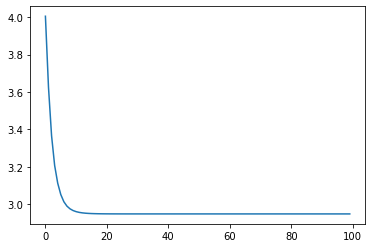

In [23]:
import matplotlib.pyplot as plt
plt.plot(loss_log)
del model
torch.cuda.empty_cache()

# Problem 84

In [25]:
# This cell takes time to execute
from gensim.models import KeyedVectors

google_word2vec = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [26]:
vocab_size = len(set(word_to_id_dict.values())) + 1
weights = np.zeros((vocab_size, embed_size))
n_words_pretrained = 0
for i, word in enumerate(word_to_id_dict.keys()):
    try:
        weights[i] = google_word2vec[word]
        n_words_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(embed_size,))
weights = torch.from_numpy(weights.astype((np.float32)))
print(n_words_pretrained, vocab_size)
del google_word2vec

6751 7492


In [35]:
class MySimpleRNNBidir(nn.Module):
    def __init__(self, embed_size, hidden_size, n_layer, output_size, emb_weights, bidirectional=False):
        super().__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.D = 2 if bidirectional else 1
        #self.emb = nn.Embedding(len(words_sorted_by_occurence)+1, embed_size, padding_idx=len(words_sorted_by_occurence))
        self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=len(words_sorted_by_occurence))
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=n_layer, nonlinearity='relu', batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(self.D * hidden_size, output_size)
    
    def forward(self, x):
        x_emb = self.emb(x)
        _, h = self.rnn(x_emb)
        y = self.fc(h.view(1, h.shape[1] ,hidden_size*self.D))
        return y.squeeze()

In [36]:
model = MySimpleRNNBidir(embed_size, hidden_size, 1, 4, weights, False)

In [37]:
dataloader = DataLoader(ds_train, batch_size=2048, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

loss_fn = nn.BCEWithLogitsLoss()
loss_log = []
model = model.cuda()
for epoch in range(100):
    loss_total = 0.0
    for data in dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        loss = loss_fn(model(x), y)
        loss_total += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch, loss_total)
    loss_log.append(loss_total)

<ipython-input-19-7d29c699be4b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i]), torch.tensor(self.y[i])


0 3.867301344871521
1 3.738545060157776
2 3.6249797344207764
3 3.527064085006714
4 3.4397067427635193
5 3.3620190024375916
6 3.294784903526306
7 3.2353904247283936
8 3.183665931224823
9 3.1392702460289
10 3.101894497871399
11 3.0706738233566284
12 3.045207977294922
13 3.0245415568351746
14 3.007958948612213
15 2.994744837284088
16 2.9843380749225616
17 2.9761965572834015
18 2.9698526263237
19 2.964877188205719
20 2.9610040187835693
21 2.9580285251140594
22 2.9557164311408997
23 2.9539166390895844
24 2.9525226056575775
25 2.9514570236206055
26 2.950631409883499
27 2.9499919712543488
28 2.949498862028122
29 2.949114441871643
30 2.9488185346126556
31 2.9485886991024017
32 2.948410391807556
33 2.9482699632644653
34 2.94816917181015
35 2.9480799436569214
36 2.948013424873352
37 2.947963833808899
38 2.947926163673401
39 2.947888821363449
40 2.9478661119937897
41 2.9478477239608765
42 2.94782891869545
43 2.9478158056735992
44 2.947805643081665
45 2.9478002190589905
46 2.947789579629898
47 2.9

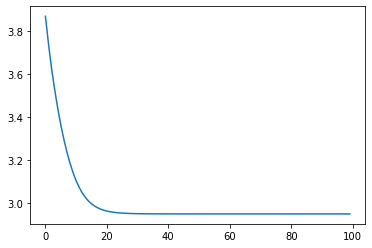

In [38]:
plt.plot(loss_log)
del model
torch.cuda.empty_cache()

# Problem 85

In [41]:
model = MySimpleRNNBidir(embed_size, hidden_size, 1, 4, weights, True)

In [42]:
dataloader = DataLoader(ds_train, batch_size=2048, shuffle=False)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

loss_fn = nn.BCEWithLogitsLoss()
loss_log = []
model = model.cuda()
for epoch in range(100):
    loss_total = 0.0
    for data in dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        loss = loss_fn(model(x), y)
        loss_total += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch, loss_total)
    loss_log.append(loss_total)

<ipython-input-19-7d29c699be4b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i]), torch.tensor(self.y[i])


0 4.096736431121826
1 4.028447270393372
2 3.964130699634552
3 3.9047322273254395
4 3.849160313606262
5 3.7967283129692078
6 3.7474005818367004
7 3.7012965083122253
8 3.65862900018692
9 3.6193503737449646
10 3.58338463306427
11 3.5506062507629395
12 3.5209648609161377
13 3.494127631187439
14 3.4698455333709717
15 3.4478805661201477
16 3.427985429763794
17 3.4099247455596924
18 3.3934929370880127
19 3.378444731235504
20 3.3646059036254883
21 3.3518322706222534
22 3.3399378657341003
23 3.3288268446922302
24 3.318365156650543
25 3.3084627389907837
26 3.299043357372284
27 3.2900218963623047
28 3.2813568711280823
29 3.2729899287223816
30 3.26487797498703
31 3.257002353668213
32 3.2492940425872803
33 3.241757392883301
34 3.2343533039093018
35 3.227078676223755
36 3.2199078798294067
37 3.212839424610138
38 3.2058574557304382
39 3.1989479660987854
40 3.1921149492263794
41 3.1853519678115845
42 3.1786614060401917
43 3.1720218658447266
44 3.1654521822929382
45 3.1589537858963013
46 3.152508378028

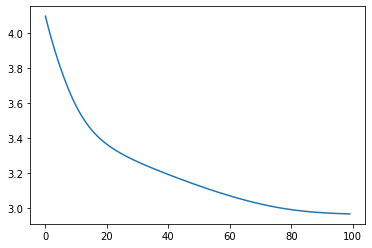

In [43]:
plt.plot(loss_log)